In [48]:
import numpy as np
import matplotlib.pyplot as plt
from nyktools.utils import set_default_style
import pandas as pd

set_default_style()
%matplotlib inline

In [2]:
document_vector = np.load('/data/processed/raw_document_vector.npy')

In [3]:
document_vector.shape

vec_norm = np.linalg.norm(document_vector, axis=1)

vec_norm = np.where(vec_norm > 0, vec_norm, 1.)

document_vector /= vec_norm[:, None]

p = 0.04

a_min = document_vector.min(axis=1).mean()
a_max = document_vector.max(axis=1).mean()

a_min, a_max

threshold = (abs(a_min) + abs(a_max)) / 2. * p

threshold

document_vector[abs(document_vector) < threshold] = .0

document_vector.shape

(7376, 18000)

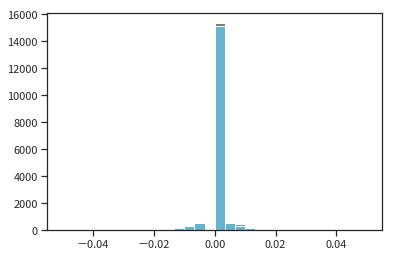

In [4]:
for v in document_vector[:10]:
    plt.hist(v, bins=np.linspace(-.05, .05, 31))

(array([ 155.,  170.,  191.,  301.,  533.,  816., 1218., 2118., 5483.,
        7015.]),
 array([0.00149132, 0.10119306, 0.20089479, 0.30059653, 0.40029826,
        0.5       , 0.59970174, 0.69940347, 0.79910521, 0.89880694,
        0.99850868]),
 <a list of 10 Patch objects>)

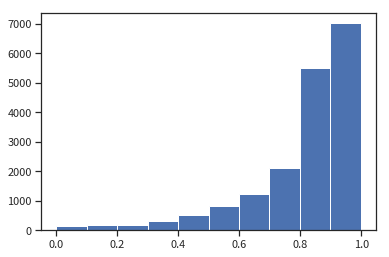

In [12]:
plt.hist(np.sum(document_vector == 0, axis=0) / document_vector.shape[0])

In [13]:
from nyktools.nlp.dataset import livedoor_news

In [31]:
docs, labels = livedoor_news()

labels = np.array(labels)

In [18]:
top_docs = np.argmax(document_vector, axis=0)

In [20]:
for i in top_docs[:10]:
    print(labels[i])

it-life-hack
dokujo-tsushin
peachy
kaden-channel
dokujo-tsushin
topic-news
it-life-hack
kaden-channel
sports-watch
topic-news


## 類似検索

文章ベクトルのユークリッド距離で検索してみる

In [178]:
query_idx = 500

print('query label: {}'.format(labels[query_idx]))
print(docs[query_idx][:200])

query label: sports-watch
宮本恒靖氏、U-23日本代表に「リスクを冒さないとダメ」
11日、国立競技場では、ロンドン五輪壮行試合＝キリンチャレンジカップ2012・U-23日本代表×U-23ニュージーランド代表の一戦が行われた。

試合は、後半26分、徳永悠平が放ったミドルシュートを相手キーパー・グリーソンが弾いたところで杉本健勇がこぼれ球をゴールに蹴り込み、先制点を挙げる。だが、後半もロスタイムに入ると、日本はイージーミス


In [179]:
v_q = document_vector[query_idx]
distance = np.linalg.norm(document_vector - v_q, axis=1)

In [180]:
_df = pd.DataFrame()
_df['labels'] = labels
_df['headline'] = [doc.split('\n')[0] for doc in docs]
_df['distance'] = distance

In [181]:
_df.sort_values('distance').head(20)

,labels,headline,distance
500,sports-watch,宮本恒靖氏、U-23日本代表に「リスクを冒さないとダメ」,0.000000
461,sports-watch,U-23日本代表、まさかのドロー。セルジオ氏は「まるで高校サッカーの決勝」,0.659019
263,sports-watch,″ご立腹″の松木氏、関塚監督の采配について苦言呈す,0.723584
39,sports-watch,【Sports Watch】日本代表、格下相手に引き分けも「収穫はあった」とキッパリ,0.765263
181,sports-watch,加藤浩次、不可解レフェリーに怒り心頭 「あんな笛見たことない」,0.791522
851,sports-watch,“日本の心臓”遠藤保仁の凄すぎるプレー、日本を救った1本のパスとは？,0.795824
22,sports-watch,日本がロンドン五輪出場。澤登正朗がオーバーエイジ枠に推したのは？,0.806352
784,sports-watch,【Sports Watch】試合から半月、対戦した吉田とテセが激闘の裏側を語る,0.809508
794,sports-watch,U-23日本代表快勝も、セルジオ越後氏「ロンドン五輪に行ったら恥をかくだけ」,0.817949
676,sports-watch,清水エスパルス、ラフプレー連発の韓国チームとの試合打ち切り,0.818147


In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [142]:
y = LabelEncoder().fit_transform(labels)

In [146]:
fold = StratifiedKFold(n_splits=5)

In [150]:
y_oof_pred = np.zeros((len(y), len(np.unique(y))), dtype=np.float32)

In [151]:
for i, (idx_train, idx_valid) in enumerate(fold.split(document_vector, y)):
    x_train, y_train = document_vector[idx_train], y[idx_train]
    x_valid, y_valid = document_vector[idx_valid], y[idx_valid]

    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict_proba(x_valid)
    y_oof_pred[idx_valid] = y_pred

ValueError: shape mismatch: value array of shape (1481,9) could not be broadcast to indexing result of shape (1481,8)

In [160]:
from sklearn.metrics import accuracy_score, classification_report

In [163]:
y_valid

array([7, 7, 7, ..., 5, 5, 5])

In [172]:
accuracy_score(y_valid, y_pred.argmax(axis=1))

0.699527346387576

In [173]:
report_dict = classification_report(y_valid, y_pred.argmax(axis=1), output_dict=True)
pd.DataFrame(report_dict)

,0,1,2,3,4,5,6,7,8,macro avg,micro avg,weighted avg
f1-score,0.683371,0.732782,0.465116,0.560386,0.818414,0.622378,0.756098,0.861035,0.605809,0.678377,0.699527,0.686348
precision,0.568182,0.707447,0.705882,0.557692,0.740741,0.760684,0.659574,0.849462,0.848837,0.710945,0.699527,0.716899
recall,0.857143,0.760000,0.346821,0.563107,0.914286,0.526627,0.885714,0.872928,0.470968,0.688622,0.699527,0.699527
support,175.000000,175.000000,173.000000,103.000000,175.000000,169.000000,175.000000,181.000000,155.000000,1481.000000,1481.000000,1481.000000
